In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


ransuuデータにて計算したコード

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み
df = pd.read_csv("../../dataset/ransuu.csv",header=None)
#df = iris.drop('species', axis=1)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape
#クラスタ数宣言
c = 5
#Kはクラスタサイズ 
K = X_size /c
max_iter = 100
distances=np.zeros((X_size,c))
best_J = 10000
m=8

In [6]:
def calculate_ep(epsilon,u_array_m):
    #_____________epsilonの更新用に定義______________
    new_epsilon = np.zeros((X_size,dimension))
    u_sum = np.sum(u_array_m,axis=1)#u_mの行ごとの合計値,epの分母

    #_____________not_alpha作成部分__________________
    not_alpha = np.zeros((X_size,dimension)) #ipsilon = alpha * not_alpha,not_alphaは絶対値の部分の分母にも使えそう
    for k in range(X_size):
        for j in range(dimension):
            sum_uxv = 0
            for i in range(c):
                sum_uxv +=u_array_m[k][i]*(X[k][j]-centroids[i][j])
            not_alpha[k][j]= sum_uxv

    ep_denominator = np.abs((not_alpha)*-1)
    alpha_kari = kappa/ep_denominator
    alpha_kari1 = 1/u_sum
    alpha_list = np.insert(alpha_kari, -1, alpha_kari1, axis=1)#alphaのminリスト作成完了
    #______________epsilonの更新___________________
    for i in range(X_size):
        for j in range(dimension):
            if alpha_list[i][j] < alpha_list[i][-1]:
                epsilon[i][j] = alpha_list[i][j]*not_alpha[i][j]*-1
            else:
                epsilon[i][j] = alpha_list[i][-1]*not_alpha[i][j]*-1
    return epsilon

In [7]:
#uの最適化部分関数作成
def u_optimize(d):
    #変数定義
    u_list = [0] * len(d)
    for i in range(len(d)):
        u_list[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u_list[i],m)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u_list[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        iti = 0
        for j in range(c):    
            iti += u_list[i+j]
        goukeiiti.append(iti==1)
    
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u_list[0:len(d):c])==K)
    goukeigo.append(sum(u_list[1:len(d):c])==K)
    goukeigo.append(sum(u_list[2:len(d):c])==K)
    goukeigo.append(sum(u_list[3:len(d):c])==K)
    goukeigo.append(sum(u_list[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u_list[i].value)
    u_array = u_value.reshape([X_size,c])
    return u_array,result

In [8]:
#クラスタ中心計算部分関数作成
def v_calculation(u_m):
    #分母計算(クラスタサイズになるはず)
    v_denominator = np.sum(u_m,axis=0)
    
    #分子計算
    v_numerator = np.zeros((c,dimension))
    for j in range(c):
        for i in range(X_size):
            v_numerator[j]+= u_m[i][j]*X[i]
   
    v = np.zeros((c,dimension ))
    for i in range(c):
        v[i] = v_numerator[i]/v_denominator[i]
    return v

In [9]:
for s in range (50):
    print(f"{s+1}回目")
    centroids = X[np.random.choice(X_size,c)]
    #____________許容範囲のκを設定_____________ 
    #許容ベクトルepsilonの初期値を設定
    #任意の範囲（[a, b): a以上、b未満）の乱数を取得したい場合
    #(b - a) * np.random.rand() + a
    a = 0.05
    b = 0.08
    kappa = (b - a) * np.random.rand(X_size,dimension) + a
    epsilon = np.zeros((X_size,dimension))
    for i in range(X_size):
        for j in range(dimension):
            ep_max = kappa[i][j]
            epsilon[i][j] = (ep_max + ep_max) * np.random.rand() - ep_max
    #print(kappa[0])
    #print(epsilon[0])
    #_________________________________________
            
            
    for epoch in range(max_iter):
        #print(f"{epoch+1}回目")
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]+epsilon[i]-centroids[j])**2))
        #uの更新
        u,J = u_optimize(d)
        u_m = u**m
        #vの更新
        new_centroids = v_calculation(u_m)
        #epsilonの更新
        epsilon = calculate_ep(epsilon,u_m)
        #print(epsilon[0])
        
        # もしも重心が変わっていなかったら終了
        if np.sum(np.abs(new_centroids-centroids))<=0.000001:
            #print(new_centroids-centroids)
            print("中心が変わらないのでbreakします！")
            break
        centroids = np.copy(new_centroids)

    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if best_J > J:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    print(s)
    print("回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(f"epsilon[0]:{epsilon[0]}")
print(np_cluster)
print(best_J)
print(best_centroids)

1回目
0
回目のクラスタリング結果↓
0.00017192767649844016
[[0.14971609 0.5379395 ]
 [0.46087009 0.72603955]
 [0.60989439 0.58859081]
 [0.37661568 0.40333382]
 [0.94003308 0.21733309]]
終了
2回目
1
回目のクラスタリング結果↓
0.0001676557672828021
[[0.58143208 0.28180686]
 [0.6242546  0.46588555]
 [0.71491891 0.67327366]
 [0.09797432 0.78648488]
 [0.15110331 0.47533479]]
終了
3回目
2
回目のクラスタリング結果↓
0.00016615196515547297
[[0.80777866 0.37127739]
 [0.1569301  0.52604196]
 [0.39128422 0.39551381]
 [0.45383279 0.62663456]
 [0.86521453 0.75421041]]
終了
4回目
3
回目のクラスタリング結果↓
0.00016012179511078743
[[0.62621399 0.43422252]
 [0.44813981 0.55960735]
 [0.48582298 0.29687169]
 [0.89378814 0.77282548]
 [0.150376   0.7494827 ]]
終了
5回目
4
回目のクラスタリング結果↓
0.00016012179511078743
[[0.62621399 0.43422252]
 [0.44813981 0.55960735]
 [0.48582298 0.29687169]
 [0.89378814 0.77282548]
 [0.150376   0.7494827 ]]
終了
6回目
5
回目のクラスタリング結果↓
0.00016012179511078743
[[0.62621399 0.43422252]
 [0.44813981 0.55960735]
 [0.48582298 0.29687169]
 [0.89378814 0.77282548

/Users/kouki/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


40
回目のクラスタリング結果↓
0.000155459786106059
[[0.13639136 0.78287155]
 [0.63250461 0.78409029]
 [0.87027224 0.3776777 ]
 [0.39300184 0.33694342]
 [0.50307966 0.53844018]]
終了
42回目
41
回目のクラスタリング結果↓
0.000155459786106059
[[0.13639136 0.78287155]
 [0.63250461 0.78409029]
 [0.87027224 0.3776777 ]
 [0.39300184 0.33694342]
 [0.50307966 0.53844018]]
終了
43回目
42
回目のクラスタリング結果↓
0.000155459786106059
[[0.13639136 0.78287155]
 [0.63250461 0.78409029]
 [0.87027224 0.3776777 ]
 [0.39300184 0.33694342]
 [0.50307966 0.53844018]]
終了
44回目
43
回目のクラスタリング結果↓
0.000155459786106059
[[0.13639136 0.78287155]
 [0.63250461 0.78409029]
 [0.87027224 0.3776777 ]
 [0.39300184 0.33694342]
 [0.50307966 0.53844018]]
終了
45回目
44
回目のクラスタリング結果↓
0.000155459786106059
[[0.13639136 0.78287155]
 [0.63250461 0.78409029]
 [0.87027224 0.3776777 ]
 [0.39300184 0.33694342]
 [0.50307966 0.53844018]]
終了
46回目
45
回目のクラスタリング結果↓
0.000155459786106059
[[0.13639136 0.78287155]
 [0.63250461 0.78409029]
 [0.87027224 0.3776777 ]
 [0.39300184 0.33694342]
 [

In [11]:
#目的関数(Fecbo-dbと同じ方の)を作成
real_D = np.empty(0)
for i in range(X_size):
    for j in range(c):
        real_D = np.append(real_D,np.sum((X[i]-best_centroids[j])**2))
real_D = real_D.reshape([X_size,c])
real_J = np.sum(real_D*u_m)
print(real_J)

0.007123022602307729


## テストコード

In [117]:
real_D = np.empty(0)

In [118]:
for i in range(X_size):
    for j in range(c):
        real_D = np.append(real_D,np.sum((X[i]-best_centroids[j])**2))

In [119]:
real_D[0]

0.01069720309835248

In [121]:
real_D[0]

array([0.0106972 , 0.55154701, 0.69212525, 0.22310936, 0.20093939])

In [122]:
u_m[0]

array([0.00398849, 0.04387936, 0.00161419, 0.00092407, 0.02056917])

In [128]:
real_D[0]

array([0.0106972 , 0.55154701, 0.69212525, 0.22310936, 0.20093939])

In [136]:
epsilon[0]

array([-0.07430066, -0.05009515])

In [131]:
arr_d = np.array(d)

In [132]:
nisemono_d = arr_d.reshape([X_size,c])

In [134]:
nisemono_d[0]

array([0.20766384, 0.04916124, 0.52979079, 0.58227547, 0.08725119])

In [139]:
#　普通にu_optimizeのresult(目的関数が正しいか算出してみる)

##　ここまでテストコード

[20. 20. 20. 20. 20.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


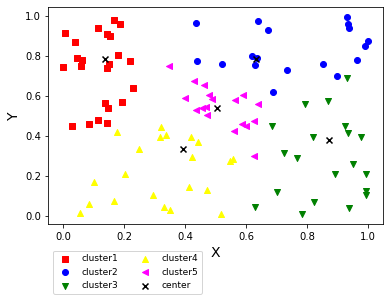

In [12]:
print(np.sum(u, axis=0))#列ごとの総和
print(np.sum(u, axis=1))#行ごとの総和
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

#fig.savefig("ToleranceFecboDb3ransuu.pdf",bbox_inches='tight')

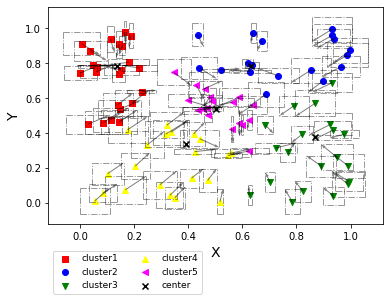

In [23]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示
#______
for i in range(X_size):
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]-epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]+epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]-epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]+epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)

    ax.quiver(X[i][0], X[i][1], epsilon[i][0], epsilon[i][1], angles='xy', scale_units='xy', scale=1,width=0.003,alpha=0.5) # 矢印プロット
#______
plt.show()
#fig.savefig("ToleranceFecboDb3ransuu_box.pdf",bbox_inches='tight')

In [14]:
np_cluster

array([2, 2, 1, 3, 0, 1, 4, 2, 0, 2, 1, 1, 3, 0, 1, 0, 4, 3, 4, 4, 3, 1,
       2, 0, 3, 3, 0, 4, 1, 1, 0, 4, 2, 1, 3, 4, 4, 3, 1, 1, 4, 2, 0, 3,
       0, 0, 1, 1, 0, 4, 3, 2, 0, 3, 4, 0, 2, 2, 3, 0, 4, 4, 3, 0, 0, 0,
       4, 1, 1, 1, 2, 3, 4, 2, 4, 0, 0, 3, 3, 3, 2, 3, 2, 2, 3, 0, 3, 2,
       3, 1, 4, 2, 0, 4, 2, 2, 0, 2, 0, 1])

## fecbo-dbらと色を合わせる
3から0  
0を2  
2を３  
4を1  
１を４

In [24]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==0, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==3, 0, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==2, 3, cluster_hensyuu_1)
cluster_hensyuu_3 = np.where(cluster_hensyuu_2==100, 2, cluster_hensyuu_2)

cluster_hensyuu_4 = np.where(cluster_hensyuu_3==1, 100, cluster_hensyuu_3)
cluster_hensyuu_5 = np.where(cluster_hensyuu_4==4, 1, cluster_hensyuu_4)
cluster_hensyuu_6= np.where(cluster_hensyuu_5==100, 4, cluster_hensyuu_5)

[20. 20. 20. 20. 20.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


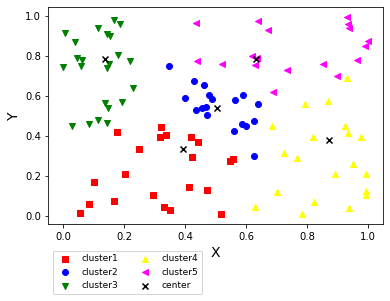

In [32]:
print(np.sum(u, axis=0))#列ごとの総和
print(np.sum(u, axis=1))#行ごとの総和
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][cluster_hensyuu_6==i], X[:, 1][cluster_hensyuu_6==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("ToleranceFecboDb8ransuu.pdf",bbox_inches='tight')

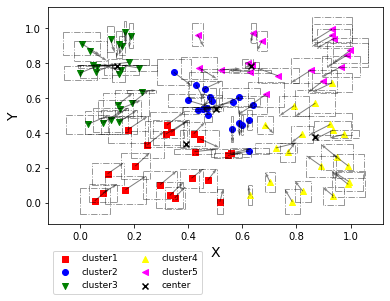

In [33]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][cluster_hensyuu_6==i], X[:, 1][cluster_hensyuu_6==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示
#______
for i in range(X_size):
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]-epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]+epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]-epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]+epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)

    ax.quiver(X[i][0], X[i][1], epsilon[i][0], epsilon[i][1], angles='xy', scale_units='xy', scale=1,width=0.003,alpha=0.5) # 矢印プロット
#______
plt.show()
fig.savefig("ToleranceFecboDb8ransuu_box.pdf",bbox_inches='tight')

In [31]:
print(np.count_nonzero(cluster_hensyuu_6==0))
print(np.count_nonzero(cluster_hensyuu_6==1))
print(np.count_nonzero(cluster_hensyuu_6==2))
print(np.count_nonzero(cluster_hensyuu_6==3))
print(np.count_nonzero(cluster_hensyuu_6==4))

21
18
23
20
18


### ここまで完成形

In [110]:
(X[0]-centroids[0])**2

array([0.2597615 , 0.03411495])

In [112]:
X[0]

array([0.93217717, 0.68933648])

In [113]:
centroids[0]

array([0.42250915, 0.50463415])

In [115]:
np.sum((X[0]-best_centroids[0])**2)

0.01069720309835248

In [ ]:
for i in range(X_size):
        for j in range(c):
            np.sum((X[i]+epsilon[i]-centroids[j])**2)

In [42]:
#------正解率の算出
dff = pd.read_csv("../../dataset/ransuu.csv",header=None)
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
seikai = iris["species"].map(size_mapping).values

seikaisuu = np.count_nonzero(cluster_hensyuu_3==seikai)
seikairitu= (np.count_nonzero(cluster_hensyuu_3==seikai))/X_size*100
print("正解率")
print(seikairitu)
print("正解数")
print(seikaisuu)
print("クラスタサイズ確認")
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))

正解率
90.66666666666666
正解数
136
クラスタサイズ確認
50
52
48


In [6]:
from ipynb.fs.full.calculator import calculate_ep

KeyError: '__package__'

In [ ]:
#_____________epsilon更新セル____________________________
#____________epsilon初期値を作成__________________
#任意の範囲（[a, b): a以上、b未満）の乱数を取得したい場合
#(b - a) * np.random.rand() + a
a = 0.05
b = 0.08
kappa = (b - a) * np.random.rand(X_size,dimension) + a
#kappaを定義
epsilon = np.zeros((X_size,dimension))
for i in range(X_size):
    for j in range(dimension):
        ep_max = kappa[i][j]
        epsilon[i][j] = (ep_max + ep_max) * np.random.rand() - ep_max
#_____________epsilonの更新用に定義______________
new_epsilon = np.zeros((X_size,dimension))

u_array_m = u_array**3
u_sum = np.sum(u_array_m,axis=1)#u_mの行ごとの合計値,epの分母

#_____________not_alpha作成部分__________________
not_alpha = np.zeros((X_size,dimension)) #ipsilon = alpha * not_alpha,not_alphaは絶対値の部分の分母にも使えそう
for k in range(X_size):
    for j in range(dimension):
        sum_uxv = 0
        for i in range(c):
            sum_uxv +=u_array_m[k][i]*(X[k][j]-centroids[i][j])
        not_alpha[k][j]= sum_uxv
        
ep_denominator = np.abs((not_alpha)*-1)
alpha_kari = kappa/ep_denominator
alpha_kari1 = 1/u_sum
alpha_list = np.insert(alpha_kari, -1, alpha_kari1, axis=1)#alphaのminリスト作成完了
#______________epsilonの更新___________________
for i in range(X_size):
    for j in range(dimension):
        if alpha_list[i][j] < alpha_list[i][-1]:
            epsilon[i][j] = alpha_list[i][j]*not_alpha[i][j]*-1
        else:
            epsilon[i][j] = alpha_list[i][-1]*not_alpha[i][j]*-1

## 許容範囲のκを設定  
## 誤差の初期値を設定

In [423]:
#任意の範囲（[a, b): a以上、b未満）の乱数を取得したい場合
#(b - a) * np.random.rand() + a
a = 0.05
b = 0.08
kappa = (b - a) * np.random.rand(X_size,dimension) + a
#kappaを定義
epsilon = np.zeros((X_size,dimension))
for i in range(X_size):
    for j in range(dimension):
        ep_max = kappa[i][j]
        epsilon[i][j] = (ep_max + ep_max) * np.random.rand() - ep_max
#epsilon初期値を作成

In [483]:
kappa.shape

(150, 4)

In [484]:
kappa[0]

array([0.06110749, 0.06642881, 0.07374297, 0.07461489])

In [485]:
epsilon[0]

array([ 0.00838405, -0.01721345, -0.06016985, -0.03735519])

## 変数定義

In [486]:
#ep_denominator　イプシロン分母
#ep_numerator イプシロン分子
new_epsilon = np.zeros((X_size,dimension))#epsilonの更新用に定義
new_epsilon.shape

(150, 4)

In [487]:
new_epsilon = np.zeros((X_size,dimension))#epsilonの更新用に定義
u_array_m = u_array**3
u_sum = np.sum(u_array_m,axis=1)#u_mの行ごとの合計値,epの分母

In [488]:
#not_alpha作成部分
not_alpha = np.zeros((X_size,dimension)) #ipsilon = alpha * not_alpha,not_alphaは絶対値の部分の分母にも使えそう
for k in range(X_size):
    for j in range(dimension):
        sum_uxv = 0
        for i in range(c):
            sum_uxv +=u_array_m[k][i]*(X[k][j]-centroids[i][j])
        not_alpha[k][j]= sum_uxv

In [444]:
alpha_kari[0]

array([0.80170722, 0.87970432, 0.91464854, 1.49178982])

In [446]:
alpha_kari1[0]

1.4514612005806218

In [447]:
alpha_list[0]

array([0.80170722, 0.87970432, 0.91464854, 1.4514612 , 1.49178982])

In [450]:
alpha_list[0][0]*not_alpha[0][0]*-1

-0.05451240043127715

In [452]:
epsilon[0][0]

-0.05451240043127715

In [490]:
ep_denominator = np.abs((not_alpha)*-1)
alpha_kari = kappa/ep_denominator
alpha_kari1 = 1/u_sum
alpha_list = np.insert(alpha_kari, -1, alpha_kari1, axis=1)#alphaのminリスト作成完了
alpha = np.amin(alpha_list,axis=1)#alpha作成完了

#epsilonの更新
for i in range(X_size):
    for j in range(dimension):
        if alpha_list[i][j] < alpha_list[i][-1]:
            epsilon[i][j] = alpha_list[i][j]*not_alpha[i][j]*-1
        else:
            epsilon[i][j] = alpha_list[i][-1]*not_alpha[i][j]*-1

In [416]:
#epsilonの更新
for i in range(X_size):
    for j in range(dimension):
        if alpha_list[i][j] < alpha_list[i][-1]:
            epsilon[i][j] = alpha_list[i][j]*not_alpha[i][j]
        else:
            epsilon[i][j] = alpha_list[i][-1]*not_alpha[i][j]
epsilon[0][0]

-0.1012520065537051

In [417]:
epsilon[0]

array([-0.10125201, -0.10987301,  0.09657633,  0.05329215])

In [377]:
np.argmin(alpha_list[0])#最小値のインデックス取得
np.amin(alpha_list[0])#最小値の値取得

4

In [393]:
np.argmin(alpha_list,axis=1)#最小値のインデックス取得
np.amin(alpha_list,axis=1)#最小値の値取得

array([-1.45095731e+00, -2.62286324e+00, -1.89806596e+00, -9.19051142e+00,
       -1.74079397e+02, -1.52304293e+00, -1.14762947e+01, -2.36940987e+03,
       -2.87734282e+00, -4.04876430e+01, -1.67329103e+01, -1.14427864e+01,
       -9.57215921e-01, -9.35505822e-01, -2.53154964e+00, -4.15630540e+00,
       -1.00127959e+00, -2.61148634e+00, -6.89821686e+01, -2.87927642e+01,
       -1.35381356e+01, -1.26380156e+02, -1.96138937e+00, -1.15943461e+00,
       -1.49154210e+01, -4.19914228e+01, -7.61199206e+01, -5.24032873e+01,
       -9.81361124e+00, -1.91008522e+00, -2.35428091e+00, -2.42999484e+01,
       -3.96422183e+00, -2.20332908e+00, -5.90997356e+02, -5.05975076e+01,
       -2.10621239e+00, -1.11301693e+02, -2.24202363e+00, -2.03954240e+01,
       -1.73298613e+02, -1.60340056e+01, -2.67812038e+00, -4.18065057e+01,
       -1.41404850e+00, -3.94528166e+00, -1.82926161e+00, -2.66627203e+00,
       -2.22532450e+01, -4.44455694e+03, -1.41537110e+00, -1.04311606e+01,
       -2.99211308e+00, -

In [394]:
not_alpha.shape

(150, 4)

In [308]:
#u_sum = np.sum(u_array_m,axis=1)#u_mの行ごとの合計値,epの分母
alpha_candidate = np.zeros((X_size,dimension+1))#alphaは（X_size,j＋１）
alpha_candidate[:,-1]=1/u_sum#alphaの最後の列に格納しておく

In [ ]:
alpha_candidate.shape

(150, 5)

In [306]:
u_array.shape

(150, 3)

In [290]:
not_alpha.shape #ipsilon = alpha * not_alpha,not_alphaは絶対値の部分の分母にも使えそう

(150, 4)

In [324]:
type(not_alpha)

numpy.ndarray

In [336]:
ep_denominator = np.abs((not_alpha)*-1)

In [339]:
ep_denominator.shape

(150, 4)

In [340]:
type(ep_denominator)

numpy.ndarray

ep_numeratorの作成 -kappa

In [341]:
type(kappa)

numpy.ndarray

In [342]:
kappa.shape

(150, 4)

In [347]:
alpha_kari = -kappa/ep_denominator

In [349]:
alpha_kari.shape

(150, 4)

In [359]:
alpha_kari1 = 1/u_sum
alpha_kari1.shape

(150,)

In [371]:
alpha_karikari = np.insert(alpha_kari, -1, alpha_kari1, axis=1)
alpha_karikari[0]

array([-0.8663483 , -0.67547973, -0.99929282,  1.42915302, -1.45095731])

In [369]:
alpha_kari[0]

array([-0.8663483 , -0.67547973, -0.99929282, -1.45095731])

In [370]:
alpha_kari1[0]

1.429153021611631

In [481]:
print(np.sum(u_array, axis=0))#列ごとの総和
print(np.sum(u_array, axis=1))#行ごとの総和

[50. 50. 50.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [157]:
#クラスタ中心計算部分関数作成
def v_calculation(u_array):
    #分母計算(クラスタサイズになるはず)
    u_array_m = u_array**3
    v_denominator = np.sum(u_array_m,axis=0)
    """
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    for i in range(X_size):
        v0_denominator += u_array[i][0]**3
        v1_denominator += u_array[i][1]**3
        v2_denominator += u_array[i][2]**3
    """
    #分子計算
    v_numerator = np.zeros((c,dimension))
    for j in range(c):
        for i in range(X_size):
            v_numerator[j]+= u_array_m[i][j]*X[i]
    """
    for i in range(X_szie):
        u_array_m[i]
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0

    for i in range(X_size):
        v0_numerator += u_array[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_array[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_array[i][2]**3*X[i]
    """
    np.zeros((c,dimension ))
    for i in range(c):
        v[i] = v_numerator[i]/v_denominator[i]
    """
    v=[0 for i in range(c)]
    v[0] = v_denominetor[i][j]*X[i]
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    """
    return v

In [ ]:
v_numerator[0]/v_denominator[0]

array([4.99945885, 3.39022676, 1.49107038, 0.25094844])

In [ ]:
v_denominator

array([25.79982586, 14.11631011, 16.55363602])

2を0\
1を2\
0を1

In [23]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==1, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==0, 1, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==2, 0, cluster_hensyuu_1)
cluster_hensyuu_3 = np.where(cluster_hensyuu_2==100, 2, cluster_hensyuu_2)

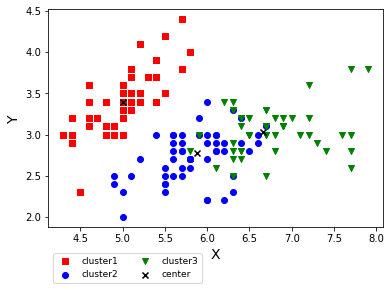

In [28]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][cluster_hensyuu_3==i], X[:, 1][cluster_hensyuu_3==i], color=colors[i],marker=markers[i])

ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1),\
           loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("iris_m3.pdf",bbox_inches='tight')

In [175]:
#------正解率の算出
dff = pd.read_csv("../iris-dataset.csv")
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
dff["species"] = iris["species"].map(size_mapping)
iris_seikai = dff.values
seikai = iris_seikai[:,4]
seikaisuu = np.count_nonzero(cluster_hensyuu_3==seikai)
seikairitu= (np.count_nonzero(cluster_hensyuu_3==seikai))/X_size*100
print("正解率")
print(seikairitu)
print("正解数")
print(seikaisuu)
print("クラスタサイズ確認")
print(np.count_nonzero(cluster_hensyuu_3==0))
print(np.count_nonzero(cluster_hensyuu_3==1))
print(np.count_nonzero(cluster_hensyuu_3==2))

FileNotFoundError: [Errno 2] No such file or directory: '../iris-dataset.csv'

In [14]:
print(np.count_nonzero(hensyuu3==0))
print(np.count_nonzero(hensyuu3==1))
print(np.count_nonzero(hensyuu3==2))
print(np.count_nonzero(hensyuu3==3))
print(np.count_nonzero(hensyuu3==4))

23
18
20
21
18


In [331]:
u_list

array([[2.80887542e-02, 3.38961295e-02, 8.51168654e-02, 3.89895755e-02,
        8.13908675e-01],
       [2.24827092e-03, 1.57081983e-02, 5.53600901e-02, 9.07081342e-01,
        1.96020987e-02],
       [8.74175158e-01, 2.17389576e-02, 5.76850510e-02, 1.78551666e-02,
        2.85456669e-02],
       [2.20306210e-02, 8.69565910e-01, 4.21344006e-02, 2.95332292e-02,
        3.67358388e-02],
       [9.11278965e-09, 1.04713998e-08, 9.99999959e-01, 1.14584518e-08,
        1.01136167e-08],
       [6.00075476e-02, 7.26335140e-02, 9.44198090e-02, 7.76956440e-02,
        6.95243485e-01],
       [3.68628832e-02, 4.56450490e-02, 8.28108920e-02, 4.96334363e-02,
        7.85047739e-01],
       [9.02618890e-02, 7.71389287e-02, 1.30797479e-01, 8.45005731e-02,
        6.17301130e-01],
       [6.97410296e-02, 6.67735606e-02, 1.00992795e-01, 6.59332712e-02,
        6.96559344e-01],
       [6.26020995e-02, 7.60603378e-02, 9.59016427e-02, 8.11986465e-02,
        6.84237273e-01],
       [1.53407570e-02, 2.5804

In [276]:
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))
print(np.count_nonzero(np_cluster==3))
print(np.count_nonzero(np_cluster==4))

21
21
15
21
21


In [247]:
#作業用セル(使用中)(制約条件変更中)（12/13）
centroids = X[np.random.choice(X_size,c)]
#dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
d=[]
for i in range(X_size):
    for j in range(c):
        d.append(np.sum((X[i]-centroids[j])**2))
#uの最適化
u = [0] * len(d)
#変数定義
for i in  range (len(d)):
    u[i] = cp.Variable()
#目的関数定義
Objective_function = 0 
for i  in range(len(d)):
    Objective_function += d[i]*cp.power(u[i],3)
objective = cp.Minimize(Objective_function)
# 制約条件の定義
zeroijou = []
goukeiiti = []
goukeigo = []
constraints = []
#0以上
for i in range (len(d)):
    zeroijou.append(u[i]>=0)
#合計1
for i in range (0,len(d),c):
    #下の式はcの値によって逐次変更しないといけない
    goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
#合計がクラスタサイズ
#下の式はcの値によって逐次変更しないといけない
goukeigo.append(sum(u[0:len(d):c])==K)
goukeigo.append(sum(u[1:len(d):c])==K)
goukeigo.append(sum(u[2:len(d):c])==K)
goukeigo.append(sum(u[3:len(d):c])==K)
goukeigo.append(sum(u[4:len(d):c])==K)
constraints.extend(zeroijou)
constraints.extend(goukeiiti)
constraints.extend(goukeigo)

# 問題を定義
problem = cp.Problem(objective, constraints)
# 最適化 (戻り値は最適化後に得られた値=最小値)
result = problem.solve()

#帰属度uと目的関数Jの値を抽出(ndarray型)
u_value = np.empty(0)#空のndarrayを作成
for i in range (len(d)):
    u_value = np.append(u_value,u[i].value)

u_list = u_value.reshape([99,5])

print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
[19.8 19.8 19.8 19.8 19.8]


In [249]:
#クラスタ中心計算部分関数作成
def v_calculation(u_vallue):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [250]:
#uの最適化部分関数作成
def u_optimize(d,J):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u[i],3)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    J = np.append(J,result)
    return u,J
#クラスタ中心計算部分関数作成
#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [463]:
np.sum(new_centroids-centroids)<=0.0000001

False

In [462]:
centroids

array([[6.66018647, 3.02832408, 5.49534818, 2.01262964],
       [5.00060886, 3.39109006, 1.49094417, 0.25014414],
       [5.87015974, 2.7786376 , 4.32919484, 1.37503987]])

In [460]:
new_centroids[0][0]= centroids[0][0]+100

In [461]:
new_centroids

array([[106.66018647,   3.02832408,   5.49534818,   2.01262964],
       [  5.00060886,   3.39109006,   1.49094417,   0.25014414],
       [  5.87015974,   2.7786376 ,   4.32919484,   1.37503987]])